In [64]:
import pandas as pd
import numpy as np
import datetime 
import os

# Scikit-learn imports
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from sklearn.utils import class_weight
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import load_model
import tensorflow as tf

# Machine learning libraries
import xgboost as xgb
import lightgbm as lgb


# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Warning settings
pd.set_option('future.no_silent_downcasting', True)


In [65]:
from scikeras.wrappers import KerasClassifier
print(type(KerasClassifier)) 

<class 'type'>


In [66]:
data = pd.read_csv('../data/Telco-Customer-Churn_cleaned.csv')
df = data.copy()

In [67]:
df.columns

Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [68]:
# Inspecting columns and unique values
def unique_value_report(df):
    rows = []
    for col in df.columns:
        value_counts = df[col].value_counts(dropna=False)
        formatted = ', '.join([f"{val} ({count})" for val, count in value_counts.items()])
        rows.append({'variable': col, 'values': formatted})
    return pd.DataFrame(rows)

unique_value_report(df)


,variable,values
0,Gender,"male (3555), female (3488)"
1,SeniorCitizen,"no (5901), yes (1142)"
2,Partner,"no (3641), yes (3402)"
3,Dependents,"no (4933), yes (2110)"
4,Tenure,"1 (613), 72 (362), 2 (238), 3 (200), 4 (176), ..."
5,PhoneService,"yes (6361), no (682)"
6,MultipleLines,"no (3390), yes (2971), no phone service (682)"
7,InternetService,"fiber optic (3096), dsl (2421), no (1526)"
8,OnlineSecurity,"no (3498), yes (2019), no internet service (1526)"
9,OnlineBackup,"no (3088), yes (2429), no internet service (1526)"


In [69]:
# 1. Identyfying columns for preprocessing

# Columns categorization
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()

## Identify binary columns with only 'yes' and 'no' values
binary_yn_cols = [col for col in df.select_dtypes(include=['object']).columns if set(df[col].unique()) == {'yes', 'no'} and col not in ['Churn']]

## Identify ordinal columns
ordinal_cols = ['Contract']
ordinal_categories = [['month-to-month', 'one year', 'two year']]  # Ordre logique des contrats

## Nominal columns: object columns with more than 2 unique values, excluding ordinal and binary columns
categorical_cols = [col for col in df.select_dtypes(include=['object']).columns if col not in ordinal_cols and df[col].nunique() > 2]


In [70]:
target_col = 'Churn'  # Target variable

# Split train / val / test
X_train, X_temp, y_train, y_temp = train_test_split(
    df.drop(columns=[target_col]), df[target_col], test_size=0.3, random_state=42, stratify=df[target_col])

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [71]:
X_train.shape, X_test.shape, X_val.shape, X_test.shape, y_val.shape, y_test.shape

((4930, 19), (1057, 19), (1056, 19), (1057, 19), (1056,), (1057,))

In [72]:
# 2. Normalisation sur les numériques
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numerical_cols])
X_val_num = scaler.transform(X_val[numerical_cols])
X_test_num = scaler.transform(X_test[numerical_cols])

X_train_num.shape, X_val_num.shape, X_test_num.shape

((4930, 3), (1056, 3), (1057, 3))

In [73]:
# 3. Encodage sur les catégorielles
# Encodage des colonnes binaires yes/no en 0/1
map = {'yes': 1, 'no': 0}
X_train[binary_yn_cols] = X_train[binary_yn_cols].replace(map)
X_val[binary_yn_cols] = X_val[binary_yn_cols].replace(map)
X_test[binary_yn_cols] = X_test[binary_yn_cols].replace(map)

# One-hot encoding for nominal categorical columns and 
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = encoder.fit_transform(X_train[categorical_cols])
X_val_cat = encoder.transform(X_val[categorical_cols])
X_test_cat = encoder.transform(X_test[categorical_cols])

# Ordinal encoding for ordinal columns
ordinal = OrdinalEncoder(categories=ordinal_categories)
X_train_ordinal = ordinal.fit_transform(X_train[ordinal_cols])
X_val_ordinal = ordinal.transform(X_val[ordinal_cols])
X_test_ordinal = ordinal.transform(X_test[ordinal_cols])

In [74]:
X_train_num = np.array(X_train_num)
X_train_cat = np.array(X_train_cat)
X_train_ordinal = np.array(X_train_ordinal)

# 4. Concatenation des numériques et catégorielles
X_train_final = np.hstack([X_train_num, X_train_cat, X_train_ordinal])
X_val_final = np.hstack([X_val_num, X_val_cat, X_val_ordinal])
X_test_final = np.hstack([X_test_num, X_test_cat, X_test_ordinal])

X_train_final.shape, X_val_final.shape, X_test_final.shape

((4930, 32), (1056, 32), (1057, 32))

In [75]:
# 5. Target variable encoding
map_target = {'yes': 1, 'no': 0}
y_train_end = y_train.replace(map_target)
y_val_end = y_val.replace(map_target)
y_test_end = y_test.replace(map_target)

## Final conversion to numpy arrays
y_train_final = y_train_end.to_numpy()
y_val_final = y_val_end.to_numpy()
y_test_final = y_test_end.to_numpy()

y_train_final = y_train_final.astype(np.float32)
y_val_final = y_val_final.astype(np.float32)
y_test_final = y_test_final.astype(np.float32)

y_train_final.shape, y_val_final.shape, y_test_final.shape

((4930,), (1056,), (1057,))

In [76]:
# 6. Class weights for imbalanced classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_final),
    y=y_train_final
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(0.680563224737714), 1: np.float64(1.8845565749235473)}


In [77]:
input_dim = X_train_final.shape[1]

def build_model(input_dim, learning_rate=0.001, num_units=64, dropout_rate=0.3, l2_reg=0.001):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(num_units, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(dropout_rate),
        layers.Dense(num_units, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid')  # Pour classification binaire
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    return model

In [78]:
model = build_model(input_dim)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,337 (24.75 KB)

 Trainable params: 6,337 (24.75 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    # mode='max',
    restore_best_weights=True,
    verbose=1
)

checkpoint_path = "data/churn_best.keras"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

tensorboard_cb = callbacks.TensorBoard(log_dir='./logs')

In [80]:
# Entraînement
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=100,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop, model_checkpoint, tensorboard_cb]
)


Epoch 1/100
153/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6284 - auc: 0.7426 - loss: 0.6897 - precision: 0.3968 - recall: 0.7660
Epoch 1: val_accuracy improved from -inf to 0.73674, saving model to best_model.h5


155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6300 - auc: 0.7438 - loss: 0.6887 - precision: 0.3982 - recall: 0.7663 - val_accuracy: 0.7367 - val_auc: 0.8402 - val_loss: 0.5983 - val_precision: 0.5022 - val_recall: 0.8107
Epoch 2/100
154/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7540 - auc: 0.8398 - loss: 0.5791 - precision: 0.5377 - recall: 0.7956
Epoch 2: val_accuracy improved from 0.73674 to 0.74811, saving model to best_model.h5


155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7539 - auc: 0.8396 - loss: 0.5792 - precision: 0.5374 - recall: 0.7953 - val_accuracy: 0.7481 - val_auc: 0.8449 - val_loss: 0.5645 - val_precision: 0.5161 - val_recall: 0.8036
Epoch 3/100
Epoch 3/100
142/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7440 - auc: 0.8292 - loss: 0.5815 - precision: 0.5162 - recall: 0.7649
Epoch 3: val_accuracy did not improve from 0.74811
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7439 - auc: 0.8296 - loss: 0.5804 - precision: 0.5157 - recall: 0.7660 - val_accuracy: 0.7462 - val_auc: 0.8473 - val_loss: 0.5606 - val_precision: 0.5135 - val_recall: 0.8143
Epoch 4/100
139/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7381 - auc: 0.8403 - loss: 0.5532 - precision: 0.5042 - recall: 0.7822
Epoch 4: val_accuracy did not improve from 0.74811
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7386 - auc: 0.8398 - loss: 0.5537 - precision: 0.5048 - recall: 0.7822 - val_accuracy: 0.7462

In [81]:
accuracy, auc, loss, precision, recall = model.evaluate(X_test_final, y_test_final, verbose=0)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

Test Accuracy: 0.5478
Test AUC: 0.7559
Test Precision: 0.5285
Test Recall: 0.7580


In [82]:
# Prédictions : probabilités
y_pred_probs = model.predict(X_test_final)

# Binarisation à 0.5 (seuil par défaut)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# y_test_final est un array de 0 et 1
print("\nClassification Report :")
print(classification_report(y_test_final, y_pred, target_names=['No Churn', 'Churn']))


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report :
              precision    recall  f1-score   support

    No Churn       0.90      0.76      0.82       776
       Churn       0.53      0.76      0.62       281

    accuracy                           0.76      1057
   macro avg       0.71      0.76      0.72      1057
weighted avg       0.80      0.76      0.77      1057



- Precision (précision) : parmi les exemples prédits positifs, combien sont réellement positifs.
- Recall (rappel) : parmi les exemples réellement positifs, combien ont été détectés (sensibilité).
- F1-score : moyenne harmonique entre précision et rappel, équilibre les deux métriques.
- Support : nombre d'exemples réels dans chaque classe.


### **Analyse des résultats**
**Classe No Churn (non-départ)**
* Précision élevée (0.90) : Quand le modèle prédit "No Churn", il a raison 90 % du temps.
* Rappel plus faible (0.74) : Le modèle détecte 74 % des vrais "No Churn", il manque donc 26 % de ces cas (faux négatifs).
* F1-score solide (0.81), ce qui indique un bon compromis.

**Classe Churn (départ)**
* Précision faible (0.52) : Parmi les prédictions "Churn", seul 52 % sont correctes. Beaucoup de faux positifs.
* Rappel plus élevé (0.78) : Le modèle détecte 78 % des vrais départs, il manque 22 % (faux négatifs).
* F1-score moyen (0.62), indiquant une performance moins satisfaisante pour cette classe.

**Performance globale**
* Accuracy de 0.75 : 75 % des prédictions globales sont correctes, mais ce chiffre est à nuancer car les classes sont déséquilibrées (plus de No Churn).
* La moyenne macro (qui donne un poids égal aux classes) est plus basse (F1-score 0.72), ce qui montre que la performance sur la classe minoritaire (Churn) tire vers le bas la moyenne.

### **Interprétation business & recommandations**
- ***Déséquilibre de classes*** : Le nombre de "No Churn" est presque 3 fois celui des "Churn". L’accuracy seule peut être trompeuse dans ce cas.
- ***Précision faible sur Churn*** : Le modèle génère beaucoup de faux positifs — en pratique, cela signifie que beaucoup de clients sont faussement identifiés comme partants.
- ***Rappel élevé sur Churn*** : Le modèle détecte une majorité des vrais clients partants, ce qui est important si l’objectif est de réduire le churn en intervenant tôt.

In [83]:
print("Matrice de Confusion :")
cm = confusion_matrix(y_test_final, y_pred)
print(cm)

Matrice de Confusion :
[[586 190]
 [ 68 213]]


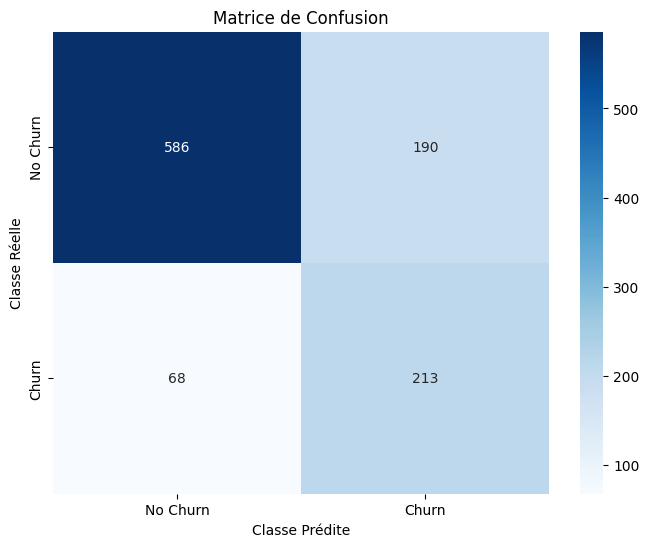

In [84]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title("Matrice de Confusion")
plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.show()

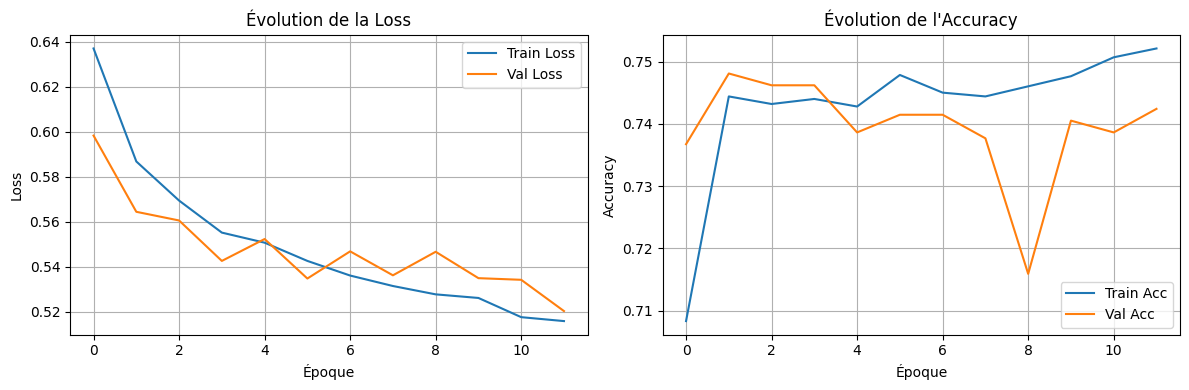

In [85]:
def plot_loss_acc(history, validation=True):
    """
    Trace la loss et l'accuracy du modèle pendant l'entraînement.
    """
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    if validation and 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Évolution de la Loss')
    plt.xlabel('Époque')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    if validation and 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Évolution de l'Accuracy")
    plt.xlabel('Époque')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    
plot_loss_acc(history)

### 3. TensorBoard

TensorBoard est un outil de visualisation et de suivi des métriques d'entraînement des modèles de Deep Learning. Il permet d'explorer les performances du modèle, de diagnostiquer les problèmes et d'optimiser les hyperparamètres. Grâce à ses fonctionnalités interactives, TensorBoard offre une vue d'ensemble des courbes de perte et d'accuracy, des distributions des poids, des gradients, et bien plus encore.

Voici quelques-unes des fonctionnalités principales de TensorBoard :
- **Suivi des métriques** : Visualisation des courbes de perte, d'accuracy, etc.
- **Exploration des distributions** : Histogrammes des poids et des gradients.
- **Visualisation du graphe du modèle** : Compréhension de la structure du réseau.
- **Analyse des hyperparamètres** : Comparaison des performances pour différents réglages.

TensorBoard est un outil essentiel pour tout projet de Deep Learning, facilitant l'interprétation des résultats et l'amélioration des modèles.

* **`log_dir`** : dossier où seront écrits les logs (scalars, histogrammes, graph, images).

* **`histogram_freq=1`** : enregistre chaque époque les distributions de poids et de gradients.

* **`write_graph=True`** : sauvegarde la définition du modèle pour visualiser le graph.

In [86]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [87]:
log_dir = os.path.join(
    "logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
)
tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,       # enregistre les histogrammes de poids chaque époque
    write_graph=True,       # sauvegarde le graph du modèle
    write_images=True
)

In [88]:
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=100,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop, model_checkpoint, tensorboard_cb]
)


Epoch 1/100
146/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7632 - auc: 0.8349 - loss: 0.5669 - precision: 0.5309 - recall: 0.7655
Epoch 1: val_accuracy did not improve from 0.74811
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7627 - auc: 0.8350 - loss: 0.5667 - precision: 0.5307 - recall: 0.7668 - val_accuracy: 0.7424 - val_auc: 0.8455 - val_loss: 0.5630 - val_precision: 0.5090 - val_recall: 0.8036
Epoch 2/100
151/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7391 - auc: 0.8235 - loss: 0.5667 - precision: 0.4924 - recall: 0.7587
Epoch 2: val_accuracy did not improve from 0.74811
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7392 - auc: 0.8238 - loss: 0.5665 - precision: 0.4930 - recall: 0.7594 - val_accuracy: 0.7396 - val_auc: 0.8460 - val_loss: 0.5599 - val_precision: 0.5055 - val_recall: 0.8143
Epoch 3/100
154/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7483 - auc: 0.8399 - loss: 0.5504 - precision: 0.5289 - recall: 0.7945
Epoch 3: val_accuracy 

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7427 - auc: 0.8393 - loss: 0.5267 - precision: 0.5142 - recall: 0.7891 - val_accuracy: 0.7595 - val_auc: 0.8513 - val_loss: 0.4964 - val_precision: 0.5312 - val_recall: 0.7893
Epoch 9/100
Epoch 9/100
147/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7520 - auc: 0.8458 - loss: 0.5119 - precision: 0.5216 - recall: 0.7923
Epoch 9: val_accuracy did not improve from 0.75947
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7518 - auc: 0.8457 - loss: 0.5122 - precision: 0.5213 - recall: 0.7931 - val_accuracy: 0.7254 - val_auc: 0.8502 - val_loss: 0.5406 - val_precision: 0.4895 - val_recall: 0.8321
Epoch 10/100
142/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7398 - auc: 0.8488 - loss: 0.5127 - precision: 0.5150 - recall: 0.8167
Epoch 10: val_accuracy did not improve from 0.75947
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7402 - auc: 0.8482 - loss: 0.5131 - precision: 0.5148 - recall: 0.8153 - val_accuracy: 0.73

In [89]:
test_acc, test_auc, test_loss, test_precesion, test_recall  = model.evaluate(X_test_final, y_test_final, verbose=0)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Precision: {test_precesion:.4f}")
print(f"Test Recall: {test_recall:.4f}")

Test Accuracy: 0.4861
Test AUC: 0.7635
Test Precision: 0.5403
Test Recall: 0.7402


In [90]:
# Prédictions : probabilités
y_pred_probs = model.predict(X_test_final)

# Binarisation à 0.5 (seuil par défaut)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# y_test_final est un array de 0 et 1
print("\nClassification Report :")
print(classification_report(y_test_final, y_pred, target_names=['No Churn', 'Churn']))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step

Classification Report :
              precision    recall  f1-score   support

    No Churn       0.89      0.77      0.83       776
       Churn       0.54      0.74      0.62       281

    accuracy                           0.76      1057
   macro avg       0.72      0.76      0.73      1057
weighted avg       0.80      0.76      0.77      1057



In [91]:
%tensorboard --logdir logs/fit

In [92]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_final, y_train_final)

In [93]:
# Entraînement
history = model.fit(
    X_train_res, y_train_res,
    validation_data=(X_val_final, y_val_final),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, model_checkpoint, tensorboard_cb]
)

Epoch 1/100
221/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7789 - auc: 0.8569 - loss: 0.4950 - precision: 0.7663 - recall: 0.8073
Epoch 1: val_accuracy did not improve from 0.75947
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7786 - auc: 0.8567 - loss: 0.4953 - precision: 0.7660 - recall: 0.8071 - val_accuracy: 0.7547 - val_auc: 0.8503 - val_loss: 0.4992 - val_precision: 0.5247 - val_recall: 0.7964
Epoch 2/100
222/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7625 - auc: 0.8485 - loss: 0.5046 - precision: 0.7529 - recall: 0.7955
Epoch 2: val_accuracy did not improve from 0.75947
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7627 - auc: 0.8487 - loss: 0.5044 - precision: 0.7529 - recall: 0.7957 - val_accuracy: 0.7528 - val_auc: 0.8498 - val_loss: 0.5200 - val_precision: 0.5219 - val_recall: 0.8071
Epoch 3/100
219/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7656 - auc: 0.8499 - loss: 0.5014 - precision: 0.7601 - recall: 0.7855
Epoch 3: val_accuracy 

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7783 - auc: 0.8517 - loss: 0.4953 - precision: 0.7646 - recall: 0.8151 - val_accuracy: 0.7633 - val_auc: 0.8502 - val_loss: 0.4916 - val_precision: 0.5379 - val_recall: 0.7607
Epoch 5/100
213/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7709 - auc: 0.8528 - loss: 0.4892 - precision: 0.7573 - recall: 0.7955
Epoch 5: val_accuracy did not improve from 0.76326
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7711 - auc: 0.8529 - loss: 0.4893 - precision: 0.7574 - recall: 0.7959 - val_accuracy: 0.7481 - val_auc: 0.8477 - val_loss: 0.5200 - val_precision: 0.5160 - val_recall: 0.8071
Epoch 6/100
217/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7793 - auc: 0.8550 - loss: 0.4881 - precision: 0.7652 - recall: 0.8032
Epoch 6: val_accuracy did not improve from 0.76326
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7792 - auc: 0.8550 - loss: 0.4881 - precision: 0.7650 - recall: 0.8031 - val_accuracy: 0.7348 - val_auc: 

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7789 - auc: 0.8576 - loss: 0.4815 - precision: 0.7657 - recall: 0.8110 - val_accuracy: 0.7661 - val_auc: 0.8478 - val_loss: 0.4928 - val_precision: 0.5403 - val_recall: 0.7893
Epoch 10/100
Epoch 10/100
212/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7781 - auc: 0.8582 - loss: 0.4824 - precision: 0.7652 - recall: 0.8029
Epoch 10: val_accuracy did not improve from 0.76610
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7782 - auc: 0.8583 - loss: 0.4822 - precision: 0.7651 - recall: 0.8034 - val_accuracy: 0.7481 - val_auc: 0.8449 - val_loss: 0.5230 - val_precision: 0.5163 - val_recall: 0.7929
Epoch 11/100
217/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7777 - auc: 0.8625 - loss: 0.4754 - precision: 0.7550 - recall: 0.8123
Epoch 11: val_accuracy did not improve from 0.76610
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7775 - auc: 0.8623 - loss: 0.4756 - precision: 0.7551 - recall: 0.8121 - val_accuracy: 0

In [94]:
# Prédictions : probabilités
y_pred_probs = model.predict(X_test_final)

# Binarisation à 0.5 (seuil par défaut)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# y_test_final est un array de 0 et 1
print("\nClassification Report :")
print(classification_report(y_test_final, y_pred, target_names=['No Churn', 'Churn']))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Classification Report :
              precision    recall  f1-score   support

    No Churn       0.89      0.78      0.83       776
       Churn       0.54      0.73      0.62       281

    accuracy                           0.76      1057
   macro avg       0.71      0.75      0.72      1057
weighted avg       0.80      0.76      0.77      1057



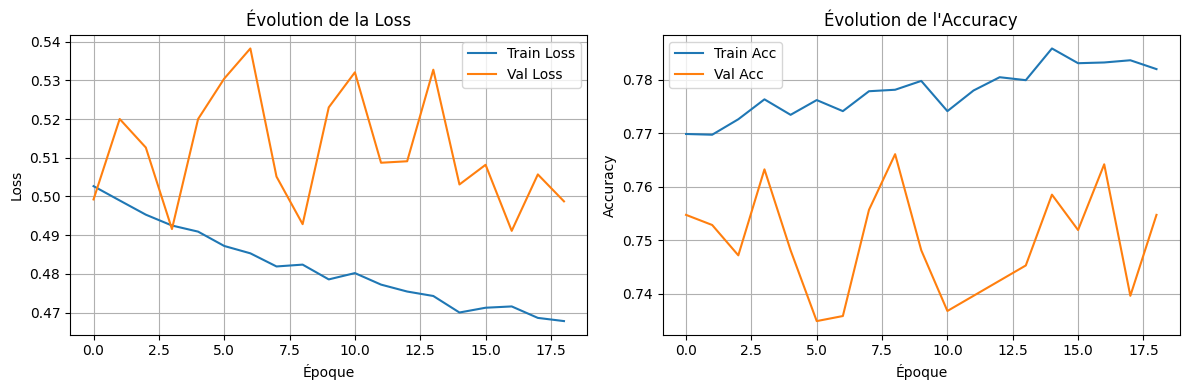

In [95]:
def plot_loss_acc(history, validation=True):
    """
    Trace la loss et l'accuracy du modèle pendant l'entraînement.
    """
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    if validation and 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Évolution de la Loss')
    plt.xlabel('Époque')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    if validation and 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Évolution de l'Accuracy")
    plt.xlabel('Époque')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    
plot_loss_acc(history)

In [99]:
def build_model_advanced(
    input_dim, 
    num_units=64, 
    dropout_rate=0.3,
    learning_rate=0.001,
    l2_reg=0.001,
    use_batchnorm=True
):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))

    # Premier bloc dense
    model.add(layers.Dense(num_units, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    if use_batchnorm:
        model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))

    # Deuxième bloc dense
    model.add(layers.Dense(num_units, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))

    # Batch Normalization et Dropout
    ## Sert à stabiliser l'entraînement et à réduire le sur-apprentissage
    if use_batchnorm:
        model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))

    # Couche de sortie
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compilation
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    return model

In [100]:
# Optimisation des hyperparamètres avec RandomizedSearchCV

model = KerasClassifier(
    model=build_model_advanced,
    model__input_dim=input_dim,
    epochs=50,
    batch_size=32,
    verbose=0,
    class_weight=class_weight_dict,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    random_state=42
)

In [101]:
# Define the hyperparameter grid
param_grid = {
    'model__num_units': [32, 64, 128],
    'model__dropout_rate': [0.2, 0.3, 0.4],
    'model__learning_rate': [0.001, 0.01],
    'model__l2_reg': [0.0001, 0.001],
    'model__use_batchnorm': [True, False],
    'batch_size': [32, 64]
}


# Create the GridSearch object
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',  # métrique adaptée au déséquilibre
    cv=3,
    verbose=2,
    n_jobs=-1
)

In [102]:
# Fit the model
grid_search.fit(X_train_final, y_train_final)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
from sklearn.utils import estimator_checks
from sklearn.utils.estimator_checks import check_estimator

check_estimator(model)


In [ ]:
def build_model_advanced(input_dim, num_units=64, dropout_rate=0.3,
                         learning_rate=0.001, l2_reg=0.001, use_batchnorm=True):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    model.add(layers.Dense(num_units, activation='relu',
                           kernel_regularizer=regularizers.l2(l2_reg)))
    if use_batchnorm:
        model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_units, activation='relu',
                           kernel_regularizer=regularizers.l2(l2_reg)))
    if use_batchnorm:
        model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

clf = KerasClassifier(
    model=build_model_advanced,
    model__input_dim=20,
    epochs=10,
    verbose=0
)

param_grid = {
    "model__num_units": [32, 64],
    "model__dropout_rate": [0.2],
    "model__learning_rate": [0.001],
    "model__l2_reg": [0.001],
    "model__use_batchnorm": [True, False],
    "batch_size": [32]
}

grid = GridSearchCV(clf, param_grid=param_grid, cv=3, scoring="roc_auc", n_jobs=-1)
grid.fit(X_train, y_train, fit__validation_data=(X_val, y_val))

In [ ]:
y_pred_proba = grid_search.best_estimator_.predict_proba(X_test_final)
y_pred = (y_pred_proba >= 0.5).astype(int)

print(classification_report(y_test_final, y_pred))

In [ ]:
# Best parameters and score
print("Test AUC:", roc_auc_score(y_test_final, y_pred_proba))
print("Best parameters found:", grid_search.best_params_)
print("Best AUC score:", grid_search.best_score_)

In [ ]:
# Best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
test_score = best_model.score(X_test_final, y_test_final)
print("Test Score:", test_score)

In [ ]:
# Save the best model
best_model.model.save('best_churn_model.h5')

In [ ]:
# Visualisation des performances du modèle
def plot_performance(y_true, y_pred_probs):
    """
    Trace les performances du modèle avec une courbe ROC et une matrice de confusion.
    """
    # Courbe ROC
    fpr, tpr, thresholds = tf.keras.metrics.roc_curve(y_true, y_pred_probs)
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, label='ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Courbe ROC')
    plt.legend()
    plt.grid()
    plt.show()

    # Matrice de confusion
    cm = confusion_matrix(y_true, (y_pred_probs > 0.5).astype(int))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.title("Matrice de Confusion")
    plt.xlabel("Classe Prédite")
    plt.ylabel("Classe Réelle")
    plt.show()
# Appel de la fonction pour visualiser les performances
plot_performance(y_test_final, y_pred_probs)

In [ ]:
import sklearn
import scikeras

print("scikit-learn version:", sklearn.__version__)
print("scikeras version:", scikeras.__version__)


In [ ]:
# Wrapper SciKeras
model = KerasClassifier(
    model=build_model_advanced,
    model__input_dim=input_dim,
    epochs=50,
    batch_size=32,
    verbose=0,
    class_weight=class_weight_dict,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    random_state=42,
    validation_split=0.2  # ✅ float (ou None si tu veux splitter toi-même)
)

# Grille d'hyperparamètres
param_grid = {
    'model__num_units': [32, 64, 128],
    'model__dropout_rate': [0.2, 0.3, 0.4],
    'model__learning_rate': [0.001, 0.01],
    'model__l2_reg': [0.0001, 0.001],
    'model__use_batchnorm': [True, False],
    'batch_size': [32, 64]
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit uniquement sur X_train_final
grid_search.fit(X_train_final, y_train_final)

In [98]:
type(KerasClassifier)


type